In [1]:
%matplotlib inline

# Imports

In [2]:
import glob
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi


###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Custom plotting parameters

In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['text.usetex'] = True

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load in the combined `.tsv` file and some notebook-wide variables


In [4]:
combined_df = pd.read_csv('../Data/MVP_data/562_associated_data/ecoli.combined.tsv', sep='\t', index_col=0)
combined_df.head()

,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,...,iCUB,GC_cds,GC_upstream,locus_tag,Gene,prot_abundance,trans_eff,essentiality_ds1,essentiality_ds2,essentiality
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,...,32.046035,0.515152,0.333333,b0001,thrL,NaN,NaN,Non-essential,Non-essential,Non-essential
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,...,55.949262,0.530654,0.433333,b0002,thrA,317.0,0.677342,Non-essential,Non-essential,Non-essential
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,...,56.062386,0.562701,0.500000,b0003,thrB,76.3,0.466450,Non-essential,Non-essential,Non-essential
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,...,53.052776,0.528361,0.566667,b0004,thrC,530.0,0.923531,Non-essential,Non-essential,Non-essential
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,...,50.705530,0.538721,0.400000,b0005,yaaX,NaN,NaN,Non-essential,Non-essential,Non-essential


In [5]:
###For prettier plotting
col_to_label_dict = {'RBS_energy': 'aSD binding energy (kcal/mol)',
                    'RBS_energy_upstream': 'Upstream aSD binding\nenergy (kcal/mol)',
                    'prot_abundance': 'Protein abundance',
                    'iCUB': 'iCUB',
                    'GC_upstream': 'Upstream GC content',
                    'GC_cds': 'Coding sequence GC content',
                    'secondary_structure': 'Start codon secondary\nstructure (kcal/mol)',
                    'secondary_structure_internal': 'Internal secondary structure (kcal/mol)',
                    'trans_eff': 'Translational efficiency'}

mean_col_to_label_dict = {}
for key, val in col_to_label_dict.items():
    if val[0]==val[0].upper():
        mean_col_to_label_dict[key] = 'Mean ' + val[0].lower() + val[1:]
    else:
        mean_col_to_label_dict[key] = 'Mean ' + val


## Example comparison between host and phage

**Note that T7 id in this database is: 7841 and I'm using the predicted annotations here**

In [6]:
virus_df = pd.read_csv('../Data/MVP_data/host_linked_genomes/562_rep_viruses/7841.clean.tsv',\
                       sep='\t', index_col=0)
print(virus_df.shape)
virus_df.head()

(49, 19)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,secondary_structure,secondary_structure_internal,iCUB,GC_cds,GC_upstream,viral_id
0,NC_001604|10760,Prodigal_v2.6.3,CDS,925,1278,64.7,+,0,ID=347_1;partial=00;start_type=ATG;rbs_motif=G...,ATGGCTATGTCTAACATGACTTACAACAACGTTTTCGACCACGCTT...,TTCACTAATAACTGCACGAGGTAACACAAG,-5.42,-0.34,-5.17,-11.35,50.525906,0.468927,0.400000,347_1
1,NC_001604|10760,Prodigal_v2.6.3,CDS,1278,1433,17.1,+,0,ID=347_2;partial=00;start_type=ATG;rbs_motif=A...,ATGTCTACTACCAACGTGCAATACGGTCTGACCGCTCAAACTGTAC...,AGTCGAGGAGTACGAGGAGGATGAAGAGTA,-9.31,-6.36,-10.17,-13.10,43.066882,0.455128,0.500000,347_2
2,NC_001604|10760,Prodigal_v2.6.3,CDS,1496,1639,13.3,+,0,ID=347_3;partial=00;start_type=ATG;rbs_motif=G...,ATGTATATGCTTACTATCGGTCTACTCACCGCTCTAGGTCTAGCTG...,TATGATTATCACTTTACTTATGAGGGAGTA,-5.82,-0.00,-8.15,-15.63,39.155014,0.458333,0.300000,347_3
3,NC_001604|10760,Prodigal_v2.6.3,CDS,1636,1797,8.1,+,0,ID=347_4;partial=00;start_type=ATG;rbs_motif=G...,ATGATGAAGCACTACGTTATGCCAATCCACACGTCCAACGGGGCAA...,CATAGGAATCATCAAAGGGGCACTACGCAA,-5.53,-3.45,-10.08,-12.54,42.406008,0.481481,0.466667,347_4
4,NC_001604|10760,Prodigal_v2.6.3,CDS,2021,3100,118.8,+,0,ID=347_5;partial=00;start_type=ATG;rbs_motif=A...,ATGAACATTACCGACATCATGAACGCTATCGACGCAATCAAAGCAC...,TCTCATAACGAACATAAAGGACACAATGCA,-4.00,-0.51,-2.19,-13.09,55.711182,0.493519,0.366667,347_5


**Get statistics and perform basic visualization**

Looking at three different assessments of "significance", ranksums test, independent t-test, and a logistic regression framework.

In [7]:
# col_name = 'RBS_energy'
col_name = 'secondary_structure'
temp_df = combined_df
print(stats.ranksums(temp_df[col_name], virus_df[col_name]))
print(stats.ttest_ind(temp_df[col_name], virus_df[col_name]))

assert len(list(temp_df['genome_id'].value_counts().keys())) == 1
host_name = temp_df['genome_id'].value_counts().keys()[0]
#
concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
concat_df['binary_predictor'] = 1
concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#
# fitted = smf.ols('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
print('Logistic regression')
print(fitted.summary())
print(fitted.pvalues)

RanksumsResult(statistic=-1.4839764785842922, pvalue=0.13781516077344036)
Ttest_indResult(statistic=-1.6549263996777208, pvalue=0.09801583597968372)
Logistic regression
                           Logit Regression Results                           
Dep. Variable:       binary_predictor   No. Observations:                 4109
Model:                          Logit   Df Residuals:                     4107
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Jun 2020   Pseudo R-squ.:                0.005520
Time:                        18:14:02   Log-Likelihood:                -264.27
converged:                       True   LL-Null:                       -265.73
Covariance Type:            nonrobust   LLR p-value:                   0.08675
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              

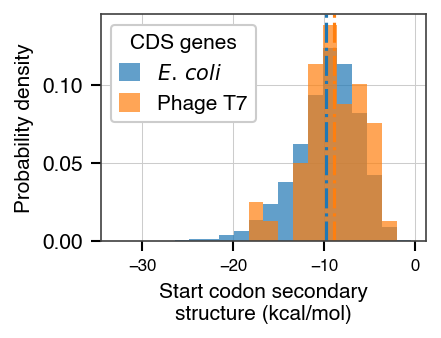

In [8]:
a, b = np.histogram(np.concatenate((temp_df[col_name].values, virus_df[col_name].values)), 20)
fig, ax = plt.subplots(figsize=(2.8,2))
ax.hist(temp_df[col_name], bins=b, label='$E.\, coli$', density=True, alpha=0.7)
ax.hist(virus_df[col_name], bins=b, label='Phage T7', density=True, alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.')
ax.axvline(virus_df[col_name].mean(), color=colors[1], linestyle='-.')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_ylabel('Probability density')
plt.legend(title='CDS genes', framealpha=1.0, handlelength=1, handleheight=1)
plt.savefig(figs_dir + '/Ecoli_T7_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

**Relationship between these two using a random effects model**

In [9]:
# x_col = 'RBS_energy'
# y_col = 'secondary_structure'
# ##Drawing lines from a mixed linear model
# fitted = smf.mixedlm('{} ~ {}'.format(y_col, x_col), data=concat_df,\
#                       groups=concat_df['genome_id']).fit()
# print(fitted.summary())

In [10]:
# fig, ax = plt.subplots(figsize=(3.2,2.2))
# ax.plot(temp_df[x_col], temp_df[y_col], marker='o', linestyle='', color=colors[0], alpha=0.05)
# ax.plot(virus_df[x_col], virus_df[y_col], marker='o', linestyle='', color=colors[1], alpha=0.5)
# #
# #
# #
# x_vals = np.linspace(-10, 0, 11)
# tempy = pd.DataFrame(x_vals, columns=[x_col])
# ax.plot(x_vals, fitted.predict(tempy)+fitted.random_effects[temp_df['genome_id'][0]][0],\
#         color=colors[6], linewidth=2)
# ax.plot(x_vals, fitted.predict(tempy)+fitted.random_effects[virus_df['genome_id'][0]][0],\
#         color=colors[3], linewidth=2)
# #
# #
# #Cleaning up the legend
# ax.plot([], [], linestyle='-', linewidth=3, color = colors[6],\
#         marker='o', markersize=7, markerfacecolor=colors[0], markeredgecolor=colors[0], label='$E.\, coli$')
# ax.plot([], [], linestyle='-', linewidth=3, color = colors[3],\
#         marker='o', markersize=7, markerfacecolor=colors[1], markeredgecolor=colors[1], label='Phage T7')

# leg = plt.legend(ncol=2, loc=8)
# for lh in leg.legendHandles: 
#     lh._legmarker.set_alpha(1)
# ax.set_xlabel(col_to_label_dict[x_col])
# ax.set_ylabel(col_to_label_dict[y_col])
# plt.savefig(figs_dir + '/Ecoli_T7_biplot.png'.format(col_name), dpi=300, bbox_inches='tight')

# Extended analysis to many *E. coli* viruses

Compare each virus separately to all *E. coli* genes

In [13]:
col_name = 'RBS_energy'
# col_name = 'secondary_structure'
temp_df = combined_df
host_mean = temp_df[col_name].mean()
###For the violin plot at the top
mean_virus = []
p_vals = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())
    
    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
    fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
    p_vals.append(fitted.pvalues[1])
truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
#
#
#
zippy = list(zip(p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant no FDR (total={}):'.format(len(p_vals)), lside, rside)
#
zippy = list(zip(correct_p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant w/ FDR(total={}):'.format(len(p_vals)), lside, rside)

N significant no FDR (total=373): 143 2
N significant w/ FDR(total=373): 98 0


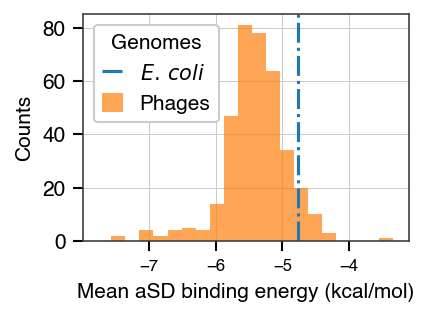

In [15]:
fig, ax = plt.subplots(figsize=(2.8, 2))
ax.hist(mean_virus, 20, color=colors[1], label='Phages', alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.', label='$E.\, coli$')
ax.set_ylabel('Counts')
ax.set_xlabel(mean_col_to_label_dict[col_name])
plt.legend(title='Genomes', framealpha=1.0, handlelength=1, handleheight=1)
ax.set_xlim(-7.99, -3.1) ###For pretty secondary_structure
# ax.set_xlim(-15, -5.5) ###For pretty RBS_energy
plt.savefig(figs_dir + '/Ecoli_allphage_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

**Comparing against different categories of *E. coli* genes**

In [22]:
col_name = 'RBS_energy'
# col_name = 'secondary_structure'

###For the violin plot at the top
mean_virus = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())
    
###For all the host information    
host_df_list = []
host_df_list.append(combined_df)
percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])
host_df_list.append(combined_df[(combined_df['essentiality']=='Essential')])
host_df_list.append(combined_df[(combined_df['essentiality']=='Non-essential')])
#
host_means = [temp_df[col_name].mean() for temp_df in host_df_list]
host_errs = [temp_df[col_name].std()/np.sqrt(temp_df.shape[0]) for temp_df in host_df_list]

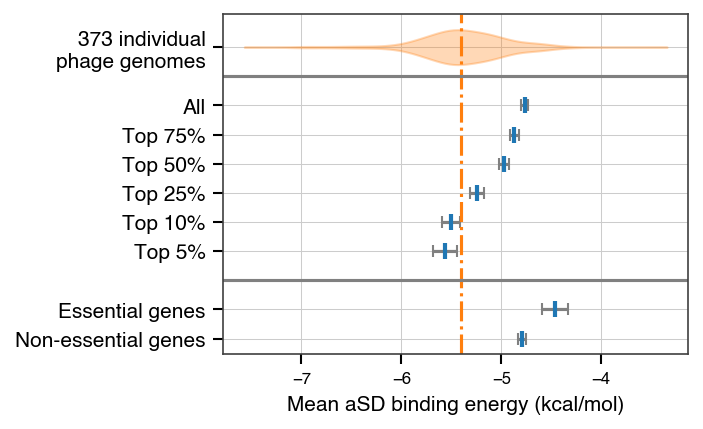

In [23]:
###Plotting
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))

fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#Plotting two here to hack the line/dot overlaps
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='|', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=2, markersize=8, mew=2)
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, capsize=3, capthick=1, elinewidth=1)
#
ax.axhline(-3, c='gray')
ax.set_xlabel(mean_col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['373 individual\nphage genomes',\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
plt.savefig(figs_dir + '/Ecoli_{}_categories.png'.format(col_name), dpi=300, bbox_inches='tight')

**And getting statistics for all those comparisons**

Currently takes a little time but... meh?

In [24]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
#
results = []
for temp_df in host_df_list:
    beta_vals = []
    p_vals = []
    for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
        virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
        concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
        concat_df['binary_predictor'] = 1
        concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
        fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
        beta_vals.append(fitted.params[1])
        p_vals.append(fitted.pvalues[1])
    truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
    zippy = list(zip(correct_p_vals, beta_vals))
    lside = len([1 for i,j in zippy if i < 0.01 and j < 0])
    rside = len([1 for i,j in zippy if i < 0.01 and j >= 0])
    results.append((lside, rside))

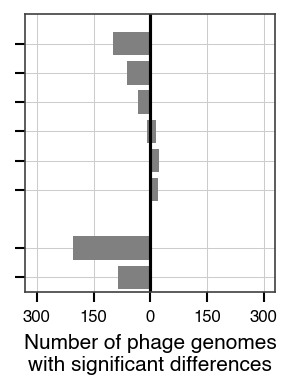

In [25]:
fig, ax = plt.subplots(figsize=(2.15,2.45))
l_bar = ax.barh(all_y_vals, [-1*i[0] for i in results], height=0.4,\
             color='gray', left=[i[1] for i in results])
r_bar = ax.barh(all_y_vals, [i[1] for i in results], height=0.4,\
            color='gray')
ax.set_yticklabels('')
ax.set_xticks([-300, -150, 0, 150, 300])
ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_xlim(-330, 330)
ax.axvline(0, c='k')
ax.set_yticks(all_y_vals[::-1])
ax.set_ylim(-4.25, 0.5)

ax.set_xlabel('Number of phage genomes\nwith significant differences')
plt.savefig(figs_dir + '/Ecoli_{}_categories_bar.png'.format(col_name), dpi=300, bbox_inches='tight')

# Multi-variate analysis

In [34]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
temp_df = combined_df
mean_diffs_a = []
mean_diffs_b = []
p_vals_a = []
p_vals_b = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
#     if '7841' not in virus_tsv:
#         continue
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    #
    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0
    fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure', data=concat_df).fit(disp=0)
    
#     fitted = smf.logit('binary_predictor ~ RBS_energy', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + GC_upstream', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ secondary_structure', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure + GC_cds + iCUB', data=concat_df).fit(disp=0)
#     beta_vals_a.append(fitted.params[1])
#     beta_vals_b.append(fitted.params[2])
    #
    mean_diffs_a.append(temp_df['RBS_energy'].mean() - virus_df['RBS_energy'].mean())
    mean_diffs_b.append(temp_df['secondary_structure'].mean() - virus_df['secondary_structure'].mean())
    #
    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

In [27]:
truth_array, correct_p_vals_a = multi.fdrcorrection(p_vals_a, alpha=0.01)
print(np.sum(truth_array))
truth_array, correct_p_vals_b = multi.fdrcorrection(p_vals_b, alpha=0.01)
print(np.sum(truth_array))

43
221


Text(0, 0.5, 'Secondary structure (host $-$ phage)')

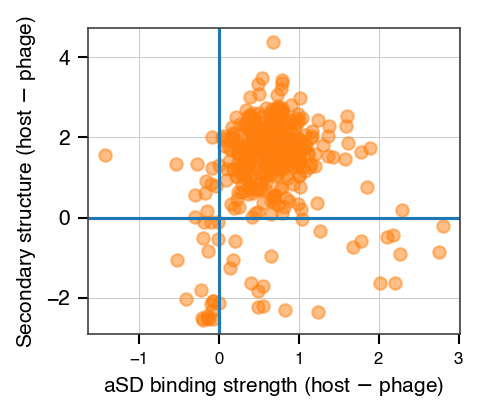

In [40]:
fig, ax = plt.subplots(figsize=(3.2,2.7))
ax.plot(mean_diffs_a, mean_diffs_b, marker='o', linestyle='', c=colors[1], alpha=0.5, label='Neither')
ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])
# ax.set_xlim(-14.5, 14.5)
# ax.set_ylim(-14.5, 14.5)
# plt.legend(loc=1, fontsize=9)
ax.set_xlabel('aSD binding strength (host $-$ phage)')
ax.set_ylabel('Secondary structure (host $-$ phage)')
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter.png'.format(col_name), dpi=300, bbox_inches='tight')

**Separating according to lifestyle**

In [41]:
lifestyle_df = pd.read_csv('../Data/MVP_data/lifestyle_results_BACPHLIP.tsv', sep='\t', index_col=2)
lifestyle_df = lifestyle_df.drop('Unnamed: 0', axis=1)
lifestyle_df = lifestyle_df[lifestyle_df['host_id']==int(562)]
print(lifestyle_df.shape)
lifestyle_df.head()

(374, 3)


,host_id,phage_lifestyle,lifestyle_probability_difference
phage_id,,,
2503,562,Temperate,0.775
6630,562,Temperate,0.850
11767,562,Temperate,1.000
5497,562,Virulent,0.625
5096,562,Virulent,1.000


In [42]:
assert len(list(combined_df['genome_id'].value_counts().keys())) == 1
host_name = combined_df['genome_id'].value_counts().keys()[0]
temp_df = combined_df
t_vals_a = []
t_vals_b = []
p_vals_a = []
p_vals_b = []
lifestyle_vals = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     if lifestyle_df.loc[int(vir_name)]['lifestyle_probability_difference'] < 0.9:
#         continue
    lifestyle_vals.append(lifestyle_df.loc[int(vir_name)]['phage_lifestyle'])   

    concat_df = pd.concat((temp_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
#     fitted = smf.logit('binary_predictor ~ RBS_energy', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + GC_upstream', data=concat_df).fit(disp=0)
    fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ secondary_structure', data=concat_df).fit(disp=0)
#     fitted = smf.logit('binary_predictor ~ RBS_energy + secondary_structure + GC_cds + iCUB', data=concat_df).fit(disp=0)
#     beta_vals_a.append(fitted.params[1])
#     beta_vals_b.append(fitted.params[2])
    #
    mean_diffs_a.append(temp_df['RBS_energy'].mean() - virus_df['RBS_energy'].mean())
    mean_diffs_b.append(temp_df['secondary_structure'].mean() - virus_df['secondary_structure'].mean())
    #
    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

In [43]:
truth_array, correct_p_vals_a = multi.fdrcorrection(p_vals_a, alpha=0.01)
print(np.sum(truth_array))
truth_array, correct_p_vals_b = multi.fdrcorrection(p_vals_b, alpha=0.01)
print(np.sum(truth_array))

43
221


Text(0, 0.5, 'T-value for secondary structure')

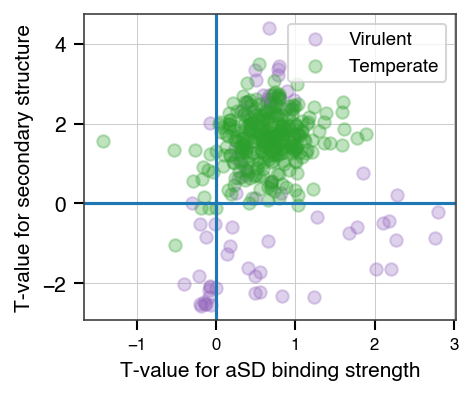

In [47]:
fig, ax = plt.subplots(figsize=(3.2,2.7))

ax.scatter([i for i,j in zip(mean_diffs_a, lifestyle_vals) if j=='Virulent'],\
           [i for i,j in zip(mean_diffs_b, lifestyle_vals) if j=='Virulent'],\
           c=colors[4], alpha=0.3, label='Virulent')
ax.scatter([i for i,j in zip(mean_diffs_a, lifestyle_vals) if j=='Temperate'],\
           [i for i,j in zip(mean_diffs_b, lifestyle_vals) if j=='Temperate'],\
           c=colors[2], alpha=0.3, label='Temperate')

ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])

plt.legend(loc=1, fontsize=9)
ax.set_xlabel('T-value for aSD binding strength')
ax.set_ylabel('T-value for secondary structure')
# plt.savefig(figs_dir + '/Ecoli_multivariate_lifestyle_scatter.png'.format(col_name), dpi=300, bbox_inches='tight')

# Significance using a stricter set of independent viruses

In [49]:
independent_set = []
with open('../Data/MVP_data/host_linked_genomes/562_independent.txt', 'r') as infile:
    for line in infile:
        independent_set.append(line.strip())
print(independent_set[:5])

['146', '170', '177', '179', '188']


In [50]:
col_name = 'secondary_structure'
###For the violin plot at the top
mean_virus = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
    if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
        continue
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())
    
###For all the host information    
host_df_list = []
host_df_list.append(combined_df)
percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])
host_df_list.append(combined_df[(combined_df['essentiality']=='Essential')])
host_df_list.append(combined_df[(combined_df['essentiality']=='Non-essential')])
#
host_means = [temp_df[col_name].mean() for temp_df in host_df_list]
host_errs = [temp_df[col_name].std()/np.sqrt(temp_df.shape[0]) for temp_df in host_df_list]

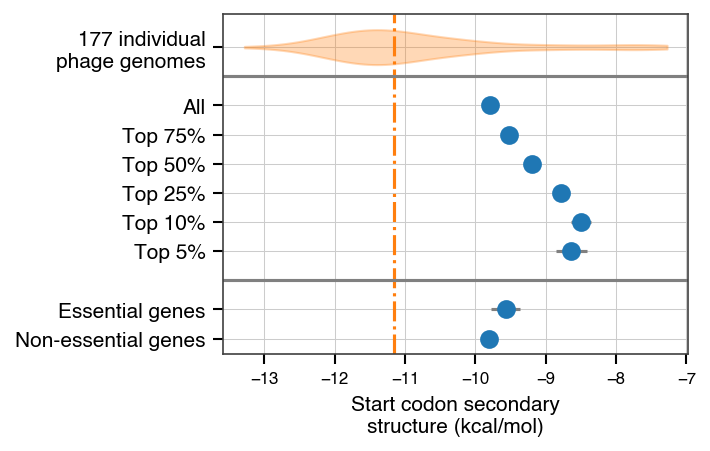

In [51]:
###Plotting
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))

fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='o', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, markersize=8)
ax.axhline(-3, c='gray')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['{} individual\nphage genomes'.format(len(mean_virus)),\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
# plt.savefig(figs_dir + '/Ecoli_{}_categories.png'.format(col_name), dpi=300, bbox_inches='tight')

In [52]:
results = []
for temp_df in host_df_list:
    lside = 0
    rside = 0
    for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/562_rep_viruses/*.clean.tsv')[:]:
        if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
            continue
        virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
        rstat, pval = stats.ranksums(temp_df[col_name], virus_df[col_name])
        if pval < 0.01:
            if virus_df[col_name].mean() < temp_df[col_name].mean():
                lside += 1
            elif virus_df[col_name].mean() >= temp_df[col_name].mean():
                rside += 1
    results.append((-lside, rside))

Text(0.5, 0, 'Number of phage genomes\nwith significant differences')

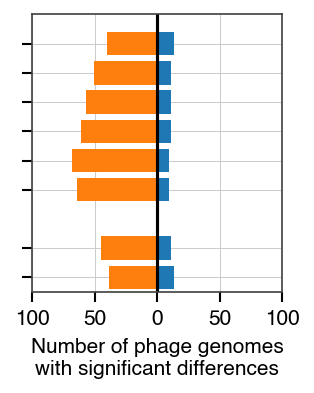

In [136]:
fig, ax = plt.subplots(figsize=(2.15,2.45))
p2 = ax.barh(all_y_vals, [i[0] for i in results], height=0.4,\
             color=colors[1], left=[i[1] for i in results])
p1 = ax.barh(all_y_vals, [i[1] for i in results], height=0.4,\
            color=colors[0])
ax.set_xlim(-250, 250)
ax.set_yticklabels('')
ax.set_xticks([-100, -50, 0, 50, 100])
ax.set_xticklabels([100, 50, 0, 50, 100])
ax.set_xlim(-100, 100)
ax.axvline(0, c='k')
ax.set_yticks(all_y_vals[::-1])
ax.set_ylim(-4.25, 0.5)

ax.set_xlabel('Number of phage genomes\nwith significant differences')
# plt.savefig(figs_dir + '/Ecoli_{}_categories_bar.png'.format(col_name), dpi=300, bbox_inches='tight')

# Separating phages according to predicted lifestyle

In [137]:
taxon_id = '562'
host_df = pd.read_csv('../Data/MVP_data/host_genomes/{}.clean.tsv'.format(taxon_id), sep='\t', index_col=0)

lifestyle_df = pd.read_csv('../Data/MVP_data/lifestyle_results_{}.tsv'.format(taxon_id), sep='\t', index_col=1)
lifestyle_df = lifestyle_df.drop('Unnamed: 0', axis=1)
lifestyle_df.head()

,1,2
0,,
1085,Temperate,0.512288
2135,Temperate,0.567532
747,Temperate,0.584016
4516,Temperate,0.564535
11438,Temperate,0.574426


In [140]:
col_name = 'secondary_structure'
mean_lytic = []
mean_temperate = []
for virus_tsv in glob.glob('../Data/MVP_data/host_linked_genomes/{}_rep_viruses/*.clean.tsv'.format(taxon_id))[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     if lifestyle_df.loc[int(vir_name)][1] < 0.55:
#         continue
#     if vir_name not in independent_set:
#         continue
    if lifestyle_df.loc[int(vir_name)][0] == 'Temperate': 
        mean_temperate.append(virus_df[col_name].mean())
    elif lifestyle_df.loc[int(vir_name)][0] == 'Lytic': 
        mean_lytic.append(virus_df[col_name].mean())
    else:
        print('Uhho')


print(len(mean_lytic), len(mean_temperate), len(mean_lytic + mean_temperate))

47 326 373


Text(0, 0.5, 'Probability density')

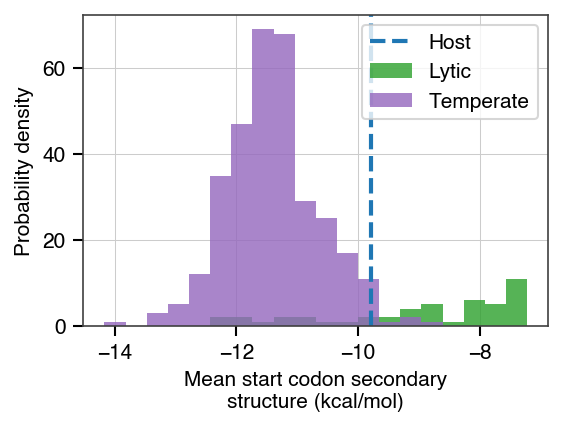

In [141]:
trash, bins = np.histogram(np.concatenate((mean_lytic, mean_temperate)), 20)
fig, ax = plt.subplots(figsize=(4, 2.75))
ax.hist(mean_lytic, bins=bins, alpha=0.8, color=colors[2], label='Lytic')
ax.hist(mean_temperate, bins=bins, alpha=0.8, color=colors[4], label='Temperate')
ax.axvline(combined_df[col_name].mean(), linestyle='--', color=colors[0], linewidth=2, label='Host')
plt.legend()
ax.set_xlabel(mean_col_to_label_dict[col_name])
ax.set_ylabel('Probability density')
# plt.savefig(figs_dir + '/Ecoli_phage_lifestyle.png', dpi=300, bbox_inches='tight')

In [ ]:
print(stats.ttest_ind(mean_lytic, mean_temperate))
print(stats.ranksums(mean_lytic, mean_temperate))

In [ ]:
virus_df

# Statistics accounting for various factors